# Proximal Policy Optimization(PPO)

## [Proximal Policy Optimization(PPO, 근접 정책 최적화) 핵심 개념]
* **정책 경사(Policy Gradient) 계열** 알고리즘
* **A2C**와 유사하지만, **정책 업데이트** 시 **제약**을 두어 안정적인 학습 가능
  * A2C, A3C, TRPO 등의 알고리즘들은 정책 업데이트 과정에서 제한이 명확하지 않음
  * 너무 과도한 업데이트로 인한 성능 퇴보 발생 가능
* **TRPO(Trust Region Policy Optimization)** 의 **개선판**
  * **TRPO**: 정책 업데이트 시 **KL 발산(Kullback-Leibler divergence)** 제약을 두어 새로운 정책이 기존 정책에서 너무 벗어나지 않도록 함
  * **PPO**: TRPO와 유사한 효과를 내면서 구현을 간소화한 **클리핑(clipping) 기법** 도입
* **핵심 아이디어**
  * 정책 업데이트 시, 새로운 정책과 기존 정책의 차이를 **클리핑(clipping)**하여 정책이 한 번에 크게 바뀌지 않도록 제약
  * **안정적인 학습** 가능
  * **구현**이 **단순**
  * 널리 사용되는 **SOTA급👍 RL 알고리즘**

## [클리핑된 서로게이트 목적 함수 (Clipped Surrogate Objective)]

* **이전 정책 대비 현재 정책의 행동 확률 비율** 정의:
  * $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$
    * $\pi_\theta(a_t|s_t)$: 현재 정책
    * $\pi_{\theta_{\text{old}}}(a_t|s_t)$: 이전 정책
* **이상적인 정책 그래디언트 업데이트**: 비율 $r_t$ 에 어드밴티지 $A_t$ 를 곱하여 기대값을 최대화
* **클리핑**: $r_t$ 가 1(기존 정책과 동일)에서 크게 벗어나는 것을 막기 위해 $r_t$ 를 일정 범위로 잘라줌
  * 예: $\epsilon = 0.2$ 라 하면, $r_t$ 를 $[1-\epsilon, 1+\epsilon]$ 범위로 **클립**
  * 클립 범위 밖에서는 이득이 더 이상 증가하거나 감소하지 못하도록 함
  * 정책이 과도하게 변화하지 않게 하여 **학습의 안정성** 보장

## [PPO 한계 및 개선 방향]

* **On-policy** 알고리즘
  * 데이터 생성 비용이 매우 큰 로봇 학습 등에서는 효율이 떨어질 수 있음
* **대안**: Off-policy 알고리즘 >> **Soft Actor-Critic SAC** (Week 10)

## [실습: PPO를 이용한 CartPole 실습]

### 1. 라이브러리 가져오기 및 하이퍼파라미터 설정

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import imageio

learning_rate = 0.0003
gamma = 0.99
lmbda = 0.95  # GAE lambda
eps_clip = 0.1  # Clipping 범위
K_epoch = 4  # PPO 업데이트 반복 횟수
T_horizon = 128 # 1 episode에서의 최대 step 수
num_episodes = 2000 # 학습 episode 횟수
early_stopping_threshold = 450.0,  # 조기종료 임계값
early_stopping_patience = 10  # 연속 조기종료 조건 만족 episode 수
gif_save_path = 'cartpole_simulation_ppo.gif' # GIF 저장 경로
progress_interval = 50  # 진행률 표시 간격

### 2. Actor-Critic 네트워크 정의

* `nn.Module`을 상속받아 Actor-Critic 네트워크를 정의
* Actor 네트워크는 상태를 입력받아 각 행동에 대한 확률 분포를 출력
* Critic 네트워크는 상태를 입력받아 상태 가치(state value)를 출력
* `init_weights`함수를 이용해 신경망 가중치를 초기화 (Xavier 초기화 기법)

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.init_weights()

    # Xavier initialization
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.actor(x), self.critic(x)

### 3. PPO 알고리즘 클래스 정의

* `PPO` 클래스는 Actor-Critic 네트워크, GAE 계산, PPO 업데이트 로직을 포함
* `get_action`: 주어진 상태에서 Actor 네트워크를 통해 행동을 샘플링하고, 해당 행동의 로그 확률을 함께 반환
* `compute_gae`: Generalized Advantage Estimation (GAE)를 계산
  * GAE는 Advantage 함수의 편향은 줄이고, 분산은 키우는 estimator
  * reward와 value function을 이용하여 advantage를 추정
  * lambda 파라미터를 통해 GAE의 bias-variance trade-off를 조절
* `update`: PPO 알고리즘의 핵심인 업데이트 로직을 수행
  * 미니배치를 사용하여 반복적으로 네트워크를 업데이트
  * PPO의 clipped surrogate objective를 계산하고, 이를 최대화하는 방향으로 Actor 네트워크를 업데이트
  * Critic 네트워크는 Value Function을 더 잘 예측할 수 있도록 Mean Squared Error(MSE) loss를 최소화하는 방향으로 업데이트

In [6]:
class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr, gamma, lmbda, eps_clip, K_epoch):
        self.model = ActorCritic(state_dim, action_dim, hidden_dim)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr) # AdamW optimizer
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps_clip = eps_clip
        self.K_epoch = K_epoch
        self.data = []

    def get_action(self, state):
        state = torch.FloatTensor(state) # Tensor 변환 + device
        probs, _ = self.model(state)  # Actor, Critic 분리 호출
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def compute_gae(self, rewards, values, next_value, dones):
      advantages = []
      gae = 0
      values = values + [next_value]

      for i in reversed(range(len(rewards))):
          delta = rewards[i] + self.gamma * values[i + 1] * (1 - dones[i]) - values[i]
          gae = delta + self.gamma * self.lmbda * (1- dones[i]) * gae
          advantages.insert(0, gae)

      advantages = torch.tensor(advantages, dtype=torch.float) # Tensor 변환, device 할당
      target_values = advantages + torch.tensor(values[:-1],dtype=torch.float) # Tensor 변환, device 할당

      return advantages, target_values


    def update(self, states, actions, log_probs, advantages, target_values):
        states = torch.stack(states)
        actions = torch.tensor(actions) # Tensor 변환, device
        log_probs = torch.stack(log_probs)

        # PPO 업데이트 (K_epoch번 반복)
        for _ in range(self.K_epoch):
            # 미니배치 인덱스 생성
            indices = torch.randperm(states.size(0))

            for start in range(0, states.size(0), T_horizon): # T_horizon 단위의 mini-batch 사용
                end = start + T_horizon
                idx = indices[start:end]

                # 미니배치 데이터
                mb_states = states[idx].detach()  # loss에 활용되는 값이므로, loss backward할 때 영향 받지 않도록, 원본에서 값만 가져온다
                mb_actions = actions[idx].detach()
                mb_log_probs = log_probs[idx].detach()
                mb_advantages = advantages[idx].detach()
                mb_target_values = target_values[idx].detach()

                # 새로운 정책의 확률, 가치
                new_probs, values = self.model(mb_states) # forward
                new_dist = Categorical(new_probs)
                new_log_probs = new_dist.log_prob(mb_actions)

                # PPO ratio 계산
                ratio = torch.exp(new_log_probs - mb_log_probs)

                # Clipped surrogate objective
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * mb_advantages
                actor_loss = -torch.min(surr1, surr2).mean() # actor loss

                # Critic loss (MSE)
                critic_loss = F.mse_loss(values, mb_target_values.unsqueeze(1))

                # Total loss
                total_loss = actor_loss + critic_loss

                # 역전파 및 최적화
                self.optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0) # gradient clipping
                self.optimizer.step()


### 4. 학습 루프 함수 정의

* `train` 함수는 PPO 에이전트를 학습시키는 주 로직
* 에피소드별로 환경과 상호작용하며 데이터를 수집 (`s, a, r, s_prime, prob_a, done`)
* `compute_gae`를 호출하여 GAE를 계산
* `update`를 호출하여 PPO 알고리즘으로 네트워크를 업데이트
* 조기 종료 조건을 검사하고, 조건을 만족하면 학습을 중단
* 학습 진행 상황을 주기적으로 출력

In [7]:
def train(env, ppo_agent):
    scores = [] # score, loss 기록

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        score = 0
        episode_states, episode_actions, episode_log_probs, episode_rewards, episode_dones = [], [], [], [], []

        # Episode별 데이터 수집
        while not done:
            action, log_prob = ppo_agent.get_action(state) # action, log prob
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # 데이터 저장 (s, a, r, s', prob_a, done)
            state_tensor = torch.from_numpy(state).float()
            episode_states.append(state_tensor)
            episode_actions.append(action)
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            episode_dones.append(done)

            state = next_state
            score += reward

        # GAE 계산
        with torch.no_grad():
          values = ppo_agent.model(torch.stack(episode_states))[1].squeeze().tolist() # [batch, 1] -> [batch]
          _, next_value = ppo_agent.model(torch.FloatTensor(next_state))
          next_value = next_value.item()

        advantages, target_values = ppo_agent.compute_gae(
            rewards=episode_rewards,
            values=values,
            next_value=next_value,
            dones=episode_dones
        )

        # PPO 업데이트
        ppo_agent.update(episode_states, episode_actions, episode_log_probs, advantages, target_values)

        # score 기록
        scores.append(score)

        # 조기 종료 검사. config에서 설정한 'progress_interval'마다 검사.
        if (episode + 1) % progress_interval == 0:
            avg_score = np.mean(scores[-progress_interval:])
            print(f"Episode {episode + 1}: Avg. Score = {avg_score:.2f}")

        # 조기종료 조건 확인.
        if np.min(scores[-early_stopping_patience:]) >= early_stopping_threshold:
            print(f"Early stopping at episode {episode + 1} (score: {score:.2f})")
            break

    return scores # score list 반환

### 5. 학습 실행 및 결과 시각화

* PPO 에이전트를 생성하고, `train` 함수를 호출하여 학습을 시작
* 학습이 끝난 후, 학습 과정에서 기록된 평균 점수를 그래프로 시각화

Episode 50: Avg. Score = 17.92
Episode 100: Avg. Score = 20.22
Episode 150: Avg. Score = 128.42
Episode 200: Avg. Score = 241.90
Episode 250: Avg. Score = 291.58
Episode 300: Avg. Score = 429.42
Early stopping at episode 345 (score: 500.00)


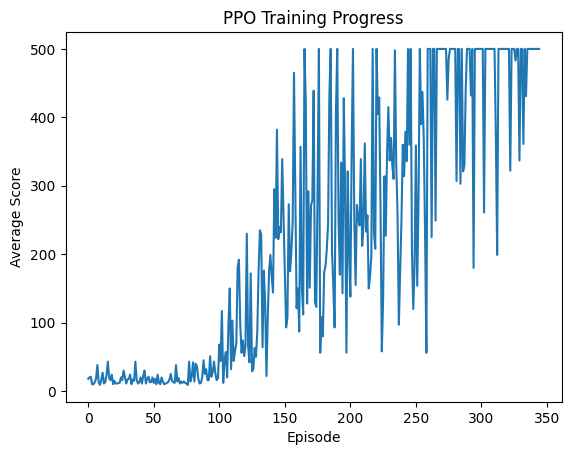

In [9]:
# PPO 에이전트 생성
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
agent = PPO(state_dim, action_dim, hidden_dim, learning_rate, gamma, lmbda, eps_clip, K_epoch)

# 학습 실행
scores = train(env, agent)

# 결과 시각화 (학습 곡선)
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.title("PPO Training Progress")
plt.show()

### 6. 학습된 에이전트 검증 및 GIF 저장

* 학습된 에이전트를 사용하여 에피소드를 실행하고, 결과를 GIF 파일로 저장
* 에피소드 동안의 총 보상을 출력

In [11]:
# 검증 (GIF 저장)
print("Generating GIF...")
frames = []
state, _ = env.reset()
done = False
truncated = False
total_reward = 0

with imageio.get_writer(gif_save_path, duration=33) as writer:  # imageio writer
    while not done:
        action, _ = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        done = terminated or truncated

        frames.append(env.render())

    # imageio를 사용하여 프레임을 GIF로 저장
    for frame in frames:
        writer.append_data(frame)

print(f"Total reward for the test episode: {total_reward}")
env.close() # 환경 종료

Generating GIF...
Total reward for the test episode: 500.0
